# Comparison of Static Grewe et. al Feature Values

Comparison of feature distributions of **benchmarks** (the GPGPU benchmarks used in CGO'17), **clgen**, and **github** (at subset of the training corpus that we can extract features from).

Histograms showing on the left the raw values, on the right the log+1 transformed values.

In [1]:
from absl import flags
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sqlalchemy as sql
from labm8 import viz
from experimental.deeplearning.clgen.closeness_to_grewe_features import grewe_features_db

FLAGS = flags.FLAGS(['argv0'])

db = grewe_features_db.Database('file:///var/phd/db/cc1.mysql?grewe_kernels?charset=utf8')

## Combined Features (except dynamic values)

We exclude dynamic values since we can set them arbitrarily, ensuring we could match any distribution.

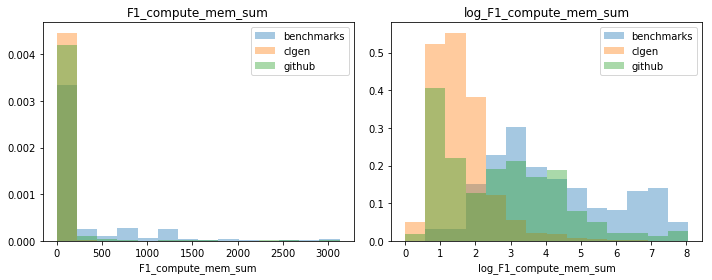

F1_compute_mem_sum
benchmarks       n=275, mean=288.87, stdev=529.62, percentiles=[0%=1 50%=44 95%=1268 99%=2659 100%=3128]
clgen            n=17373, mean=8.15, stdev=30.62, percentiles=[0%=0 50%=4 95%=22 99%=101 100%=816]
github           n=3414, mean=356.53, stdev=1526.23, percentiles=[0%=0 50%=14 95%=2249 99%=6247 100%=19057]



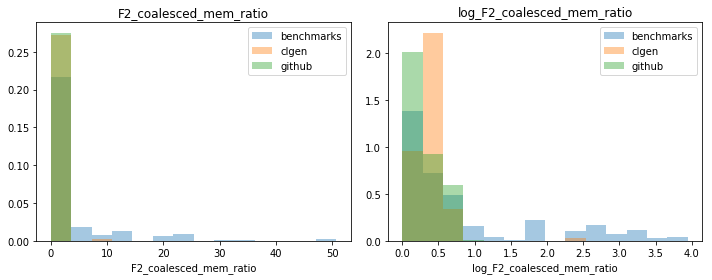

F2_coalesced_mem_ratio
benchmarks       n=275, mean=3.17, stdev=7.73, percentiles=[0%=0 50%=0 95%=19 99%=37 100%=50]
clgen            n=17373, mean=0.12, stdev=1.16, percentiles=[0%=0 50%=0 95%=0 99%=10 100%=20]
github           n=3414, mean=0.04, stdev=0.98, percentiles=[0%=0 50%=0 95%=0 99%=0 100%=28]



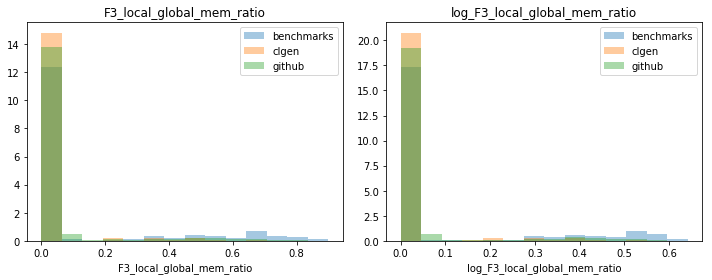

F3_local_global_mem_ratio
benchmarks       n=275, mean=0.00, stdev=0.00, percentiles=[0%=0 50%=0 95%=0 99%=0 100%=0]
clgen            n=17373, mean=0.00, stdev=0.00, percentiles=[0%=0 50%=0 95%=0 99%=0 100%=0]
github           n=3414, mean=0.00, stdev=0.00, percentiles=[0%=0 50%=0 95%=0 99%=0 100%=0]



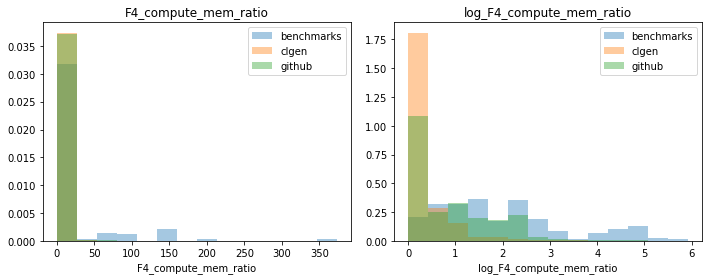

F4_compute_mem_ratio
benchmarks       n=275, mean=22.38, stdev=49.88, percentiles=[0%=0 50%=4 95%=139 99%=209 100%=372]
clgen            n=17373, mean=0.63, stdev=3.67, percentiles=[0%=0 50%=0 95%=2 99%=12 100%=138]
github           n=3414, mean=5.70, stdev=57.37, percentiles=[0%=0 50%=0 95%=8 99%=55 100%=1921]



In [22]:
def CombineOrigins(df):
    df['origin'] = [x.split('_')[0] for x in df['origin']]
    return df

RATIO_VALUES = [
    ('F1_compute_mem_sum', grewe_features_db.OpenCLKernelWithRawGreweFeatures.grewe_compute_operation_count + 
     grewe_features_db.OpenCLKernelWithRawGreweFeatures.grewe_global_memory_access_count),
    ('F2_coalesced_mem_ratio', grewe_features_db.OpenCLKernelWithRawGreweFeatures.grewe_coalesced_memory_access_count /
                (grewe_features_db.OpenCLKernelWithRawGreweFeatures.grewe_global_memory_access_count + float(1))),
    ('F3_local_global_mem_ratio', grewe_features_db.OpenCLKernelWithRawGreweFeatures.grewe_local_memory_access_count /
            (grewe_features_db.OpenCLKernelWithRawGreweFeatures.grewe_global_memory_access_count + float(1))),
    ('F4_compute_mem_ratio', grewe_features_db.OpenCLKernelWithRawGreweFeatures.grewe_compute_operation_count /
                (grewe_features_db.OpenCLKernelWithRawGreweFeatures.grewe_global_memory_access_count + float(1))),
]

for name, val in RATIO_VALUES:
    with db.Session() as s:
        df = pd.read_sql(
            s.query(val, grewe_features_db.OpenCLKernelWithRawGreweFeatures.origin).statement, s.bind)
    df = CombineOrigins(df)
    df.columns = [name, 'origin']
    df[f'log_{name}'] = np.log1p(df[name])
    benchmarks_only = df[df['origin'] == 'benchmarks']
    bins = np.linspace(min(df[name]), max(benchmarks_only[name]), 15)
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 2, 1)
    Distplot(x=name, group='origin', data=df, bins=bins, norm_hist=True, ax=ax)
    plt.legend()
    plt.title(name)

    ax = fig.add_subplot(1, 2, 2)    
    bins = np.linspace(min(df[f'log_{name}']), max(benchmarks_only[f'log_{name}']), 15)
    Distplot(x=f'log_{name}', group='origin', data=df, bins=bins, norm_hist=True, ax=ax)
    plt.legend()
    plt.title(f'log_{name}')
    viz.Finalize(figsize=(10, 4))
    
    print(name)
    for group in sorted(set(df['origin'])):
        print(f'{group:16s}', SummarizeInts(df[df['origin'] == group][name]))
    print()

## Raw Feature Values

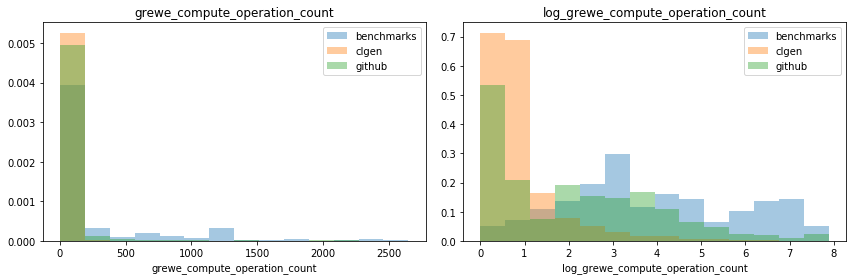

grewe_compute_operation_count
benchmarks       n=275, mean=261.52, stdev=479.34, percentiles=[0%=0 50%=32 95%=1260 99%=2229 100%=2650]
clgen            n=17373, mean=4.89, stdev=27.29, percentiles=[0%=0 50%=1 95%=14 99%=88 100%=729]
github           n=3414, mean=316.54, stdev=1378.91, percentiles=[0%=0 50%=7 95%=2021 99%=5614 100%=17145]



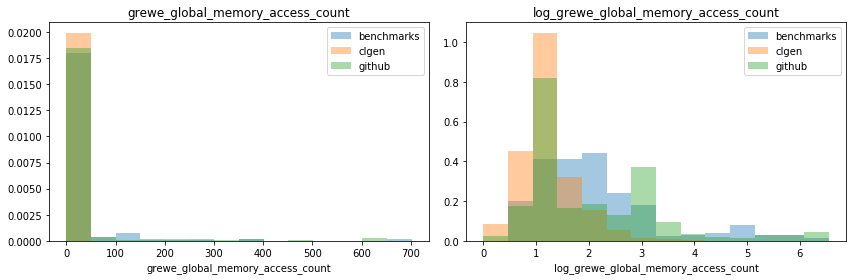

grewe_global_memory_access_count
benchmarks       n=275, mean=27.35, stdev=79.23, percentiles=[0%=1 50%=6 95%=147 99%=387 100%=702]
clgen            n=17373, mean=3.26, stdev=4.34, percentiles=[0%=0 50%=2 95%=8 99%=18 100%=124]
github           n=3414, mean=39.98, stdev=153.07, percentiles=[0%=0 50%=4 95%=223 99%=632 100%=1912]



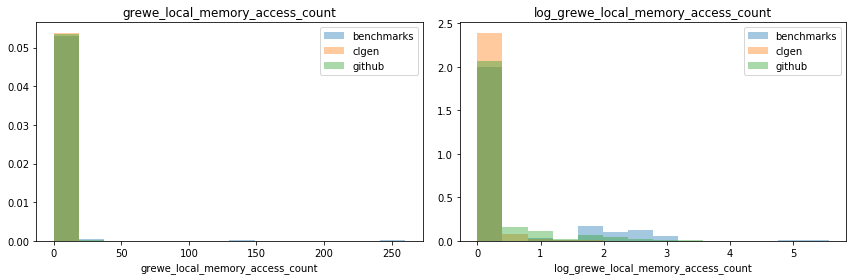

grewe_local_memory_access_count
benchmarks       n=275, mean=3.16, stdev=17.83, percentiles=[0%=0 50%=0 95%=13 99%=21 100%=260]
clgen            n=17373, mean=0.11, stdev=1.12, percentiles=[0%=0 50%=0 95%=0 99%=2 100%=54]
github           n=3414, mean=0.88, stdev=5.53, percentiles=[0%=0 50%=0 95%=4 99%=15 100%=225]



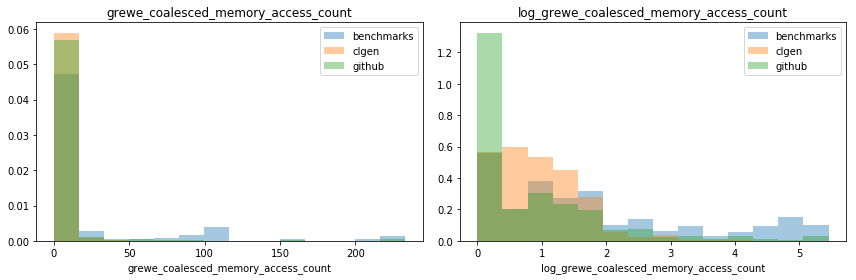

grewe_coalesced_memory_access_count
benchmarks       n=275, mean=23.63, stdev=49.08, percentiles=[0%=0 50%=3 95%=112 99%=232 100%=233]
clgen            n=17373, mean=2.53, stdev=4.53, percentiles=[0%=0 50%=2 95%=7 99%=20 100%=123]
github           n=3414, mean=33.42, stdev=153.39, percentiles=[0%=0 50%=1 95%=219 99%=631 100%=1912]



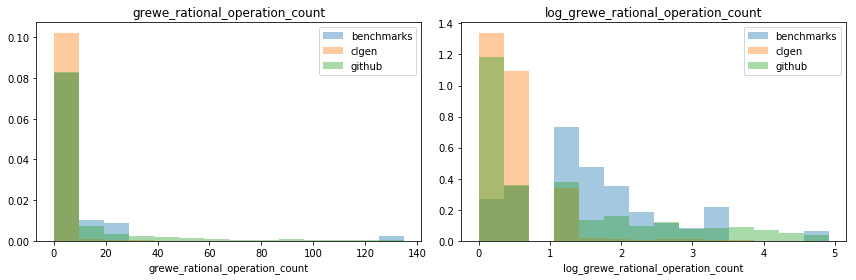

grewe_rational_operation_count
benchmarks       n=275, mean=8.55, stdev=19.96, percentiles=[0%=0 50%=4 95%=23 99%=135 100%=135]
clgen            n=17373, mean=1.06, stdev=3.52, percentiles=[0%=0 50%=1 95%=2 99%=13 100%=94]
github           n=3414, mean=44.80, stdev=159.71, percentiles=[0%=0 50%=2 95%=287 99%=630 100%=1919]



In [23]:
RAW_FEATURE_COLUMNS = [
    'grewe_compute_operation_count',
    'grewe_global_memory_access_count',
    'grewe_local_memory_access_count',
    'grewe_coalesced_memory_access_count',
    'grewe_rational_operation_count',  # This feature was used in our extended feature set.
    # 'grewe_atomic_operation_count',  # This feature wasn't used at all.
]

for feature in RAW_FEATURE_COLUMNS:
    with db.Session() as s:
        df = pd.read_sql(
            s.query(getattr(grewe_features_db.OpenCLKernelWithRawGreweFeatures, feature),
                    grewe_features_db.OpenCLKernelWithRawGreweFeatures.origin).statement, s.bind)
    df = CombineOrigins(df)
    df[f'log_{feature}'] = np.log1p(df[feature])
    benchmarks_only = df[df['origin'] == 'benchmarks']
    bins = np.linspace(min(df[feature]), max(benchmarks_only[feature]), 15)
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 2, 1)
    Distplot(x=feature, group='origin', data=df, bins=bins, norm_hist=True, ax=ax)
    plt.legend()
    plt.title(feature)

    ax = fig.add_subplot(1, 2, 2)    
    bins = np.linspace(min(df[f'log_{feature}']), max(benchmarks_only[f'log_{feature}']), 15)
    Distplot(x=f'log_{feature}', group='origin', data=df, bins=bins, norm_hist=True, ax=ax)
    plt.legend()
    plt.title(f'log_{feature}')
    viz.Finalize(figsize=(12, 4))
    
    print(feature)
    for group in sorted(set(df['origin'])):
        print(f'{group:16s}', SummarizeInts(df[df['origin'] == group][feature]))
    print()